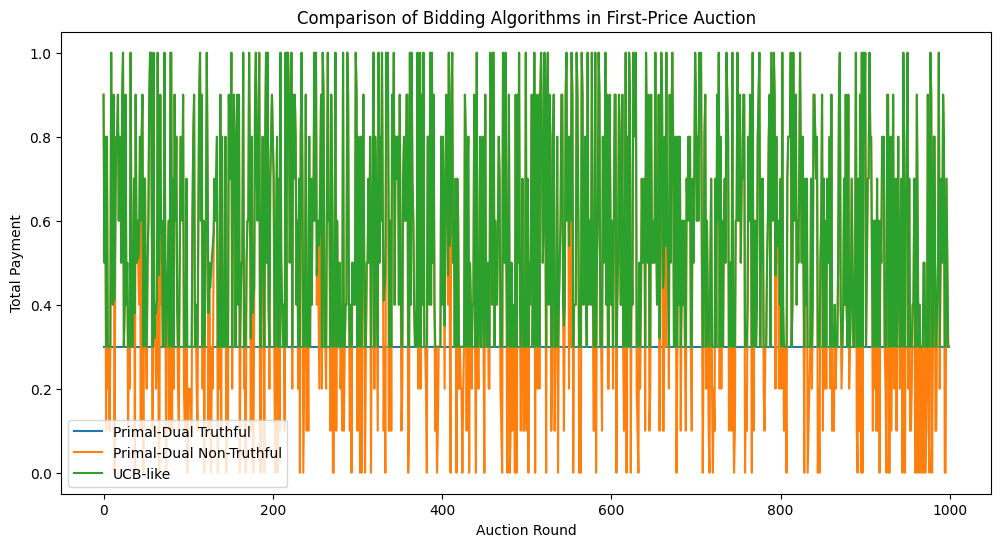

In [18]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from bidding_agents import MultiplicativePacingAgent as PrimalDualTruthful
from bidding_agents import FFMultiplicativePacingAgent as PrimalDualNonTruthful
from bidding_agents import ucblike as UCB
from environment import FirstPriceAuction


# Simulate the auction with different algorithms
def simulate_auction(num_bidders, budget, T, eta, valuation, bids_set):
    # Initialize the auction environment
    auction = FirstPriceAuction(np.ones(num_bidders))
    
    # Initialize the bidding algorithms
    truthful_bidders = PrimalDualTruthful(valuation, budget, T, eta)
    non_truthful_bidders = PrimalDualNonTruthful(bids_set, valuation, budget, T, eta)
    ucb_bidders = UCB(B,T,1,valuation,discretization=20, range=0.1)
    
    # Run the auction for the specified number of rounds
    results = {'truthful': [], 'non_truthful': [], 'ucb': []}
    for t in range(T):
        bids_truthful = truthful_bidders.bid()
        bids_non_truthful = non_truthful_bidders.bid()
        bid_ucb = ucb_bidders.bid()

        bids = np.hstack((bids_truthful, bids_non_truthful, bid_ucb))
        winners, payments_per_click = auction.round(bids=bids)

        # Update UCB algorithm with the reward
        other_bids = np.hstack((bids_truthful, bids_non_truthful))
        my_win = int(winners==0)
        m_t = other_bids.max(axis=0)
        f_t, c_t = (valuation-m_t)*my_win, m_t*my_win
        ucb_bidders.update(f_t, c_t)
        
        # Record results
        results['truthful'].append(np.sum(bids_truthful))
        results['non_truthful'].append(np.sum(bids_non_truthful))
        results['ucb'].append(payments_per_click)
    
    return results

# Set parameters and run the simulation
num_bidders = 3
B = 500
T = 1000
eta = 0.1
my_valuation = 0.6
available_bids = np.linspace(0,1,11)

results = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results['truthful'], label='Primal-Dual Truthful')
plt.plot(results['non_truthful'], label='Primal-Dual Non-Truthful')
plt.plot(results['ucb'], label='UCB-like')
plt.xlabel('Auction Round')
plt.ylabel('Total Payment')
plt.legend()
plt.title('Comparison of Bidding Algorithms in First-Price Auction')
plt.show()